In [137]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import ensemble
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
%matplotlib inline

## Model Cancer Diagnosis

I want to make a model that can predict a whether or not a tumor will be diagnosed as benign or malignant, based on certain measurements. Not only that, but I also want to better understand what measurement is most important when diagnosing a tumor.

To do this, I will use data from the Wisconson Breat Cancer Research Association to train my model. The data contains measures on the tumors of 699 subjects and whether or not they were malignant.

In [138]:
cancer = pd.read_csv('C:\Code\Data\\breast_cancer.csv')
display(cancer.head())
print(cancer.shape)

,1000025,5,1,1.1,1.2,2,1.3,3,1.4,1.5,2.1
0,1002945,5,4,4,5,7,10,3,2,1,2
1,1015425,3,1,1,1,2,2,3,1,1,2
2,1016277,6,8,8,1,3,4,3,7,1,2
3,1017023,4,1,1,3,2,1,3,1,1,2
4,1017122,8,10,10,8,7,10,9,7,1,4


(698, 11)


The data apparently needs much cleaning, having what should be one of the rows as the column names. I will need to fix that.  Also, since my data should be all numeric, I want to make sure it has no nulls or non-numeric values before I model with it.

In [139]:
# set old column to a placeholder to put it in as a new row
newrow = cancer.columns
# set dataframes columns to their proper names
cancer.columns = ['IDNum','Thickness','Size_Uniformity','Shape_Uniformity','Adhesion','Epithelial_Size',
                     'Bare_Nuclei','Chromatin','Normal_Nucleoli','Mitoses','Class']
display(cancer.head())

,IDNum,Thickness,Size_Uniformity,Shape_Uniformity,Adhesion,Epithelial_Size,Bare_Nuclei,Chromatin,Normal_Nucleoli,Mitoses,Class
0,1002945,5,4,4,5,7,10,3,2,1,2
1,1015425,3,1,1,1,2,2,3,1,1,2
2,1016277,6,8,8,1,3,4,3,7,1,2
3,1017023,4,1,1,3,2,1,3,1,1,2
4,1017122,8,10,10,8,7,10,9,7,1,4


In [140]:
#attempt to convert all columns to float, if I cannot, print which row makes it impossible.
for i in range(0,len(cancer.columns)):
    try:
        cancer.iloc[:,i].astype(float)
    except:
        print("Column(s) which could not be converted: ",cancer.columns[i])

Column(s) which could not be converted:  Bare_Nuclei


In [141]:
# make the class outcome variable between 0 and 1
cancer.Class = np.where(cancer.Class==4,1,0)

In [142]:
print(cancer['Bare_Nuclei'].value_counts())

1     401
10    132
2      30
5      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: Bare_Nuclei, dtype: int64


It seems the feature mislabeled 'Bare Nuclei', cannot be converted into a float type because it has many values marked with a '?', 16 in fact.  With how little data I have, I am hesitant to throw away any rows, but at the same time, I do not want to throw away any features, either.

To make the best model I can, I will test how my model will function when I drop the problem data points to preserve the most features, versus when I drop the whole problem feature column, preserving the most data points.

# Making Two Modeling Sets

I will make 2 versions of my data and test the accuracy of modeling both of them.  The first one will be called the 'dropped row' or 'dr' version of my data and the second will the called the 'dropped column' or 'dc' version of my data.

In [148]:
# make a list of the '?' instances in the 1.3 column
null_index = cancer[cancer['Bare_Nuclei']=='?'].index
null_index = list(null_index)
# drop the problem indeces from the dr data
cancer_dr = cancer.drop(null_index)
cancer_dr['Bare_Nuclei'] = cancer_dr['Bare_Nuclei'].astype(float)

# drop the problem feature from the dc data
cancer_dc = cancer.drop('Bare_Nuclei',axis=1)

In [75]:
print('Dropped Row Shape:')
print(cancer_dr.shape)
print('\nOutcome Counts:')
print(cancer_dr['Class'].value_counts())
print('\nDropped Column Shape:')
print(cancer_dc.shape)
print('\nOutcome Counts:')
print(cancer_dc['Class'].value_counts())

Dropped Row Shape:
(682, 11)

Outcome Counts:
0    443
1    239
Name: Class, dtype: int64

Dropped Column Shape:
(698, 10)

Outcome Counts:
0    457
1    241
Name: Class, dtype: int64


So the dropped row data is now missing 16 of it's indeces, but it gets to keep a whole dimiension to its data. Complicating things, even though the dropped columns data got to keep slightly less data points as a whole, is has ended up with slightly more balanced outcome classes in the end It will be interesting to see which models better.

In [76]:
# create model variables for dr data
X_dr = cancer_dr.drop(['IDNum','Class'], axis=1)
Y_dr = cancer_dr.Class
# create model variables for dc data
X_dc = cancer_dc.drop(['IDNum','Class'], axis=1)
Y_dc = cancer_dc.Class

# Running Models

Now that I have both my dropped column and dropped row dataset, I can begin modeling. As I do, I will compare both which model type performs best and which data type, dropped column or dropped row, preform best. 

I predeict dropped row will preform better, since it save the most 'boxes' of data thus keeping the most information, but it couldn't hurt to see.

In [106]:
# make score data frame to hold model records
scores = pd.DataFrame()

## Boosted Decision Trees

In [110]:
# set boosted decision tree dropped row model
bdt_dr = ensemble.GradientBoostingClassifier()

bdt_dr.fit(X_dr,Y_dr)

Y_predbdt_dr = bdt_dr.predict(X_dr)

# set boosted decision tree dropped row model
bdt_dc = ensemble.GradientBoostingClassifier()

bdt_dc.fit(X_dc,Y_dc)

Y_predbdt_dc = bdt_dc.predict(X_dc)

In [111]:
ben_dr, mal_dr = confusion_matrix(Y_dr, Y_predbdt_dr)
if mal_dr[0] == 0:
    type2_dr = 0
else:
    type2_dr = mal_dr[0]/(mal_dr[0]+mal_dr[1])
print("Dropping Problem Rows")
print('\nRandom Forest Error Score:')
print(bdt_dr.score(X_dr,Y_dr))
cvscore = cross_val_score(bdt_dr, X_dr, Y_dr)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscore.mean(),2),round(cvscore.std()*2,2)))
print('\nType II Error Percentage:')
print(round(type2_dr*100,2),"%")
print('\nConfusion Matrix:')
print(confusion_matrix(Y_dr, Y_predbdt_dr))


ben_dc, mal_dc = confusion_matrix(Y_dc, Y_predbdt_dc)
if mal_dc[0] == 0:
    type2_dc = 0
else:
    type2_dc = mal_dc[0]/(mal_dc[0]+mal_dc[1])
print("\n\nDropping Problem Columns")
print('\nRandom Forest Error Score:')
print(bdt_dc.score(X_dc,Y_dc))
cvscore = cross_val_score(bdt_dc, X_dc, Y_dc)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscore.mean(),2),round(cvscore.std()*2,2)))
print('\nType II Error Percentage:')
print(round(type2_dc*100,2),"%")
print('\nConfusion Matrix:')
print(confusion_matrix(Y_dc, Y_predbdt_dc))

scores['BoostedDT'] = [bdt_dr.score(X_dr,Y_dr),type2_dr,bdt_dc.score(X_dc,Y_dc),type2_dc]

Dropping Problem Rows

Random Forest Error Score:
1.0

Cross Validation Score:
0.96% +/- 0.03%

Type II Error Percentage:
0 %

Confusion Matrix:
[[443   0]
 [  0 239]]


Dropping Problem Columns

Random Forest Error Score:
0.995702005730659

Cross Validation Score:
0.95% +/- 0.06%

Type II Error Percentage:
0.41 %

Confusion Matrix:
[[455   2]
 [  1 240]]


## Random Forest

In [87]:
# set random forest dropped row model
rfc_dr = ensemble.RandomForestClassifier()

rfc_dr.fit(X_dr,Y_dr)

Y_predrfc_dr = rfc_dr.predict(X_dr)

In [88]:
# set random forest dropped column model
rfc_dc = ensemble.RandomForestClassifier()

rfc_dc.fit(X_dc,Y_dc)

Y_predrfc_dc = rfc_dc.predict(X_dc)

In [108]:
ben_dr, mal_dr = confusion_matrix(Y_dr, Y_predrfc_dr)
if mal_dr[0] == 0:
    type2_dr = 0
else:
    type2_dr = mal_dr[0]/(mal_dr[0]+mal_dr[1])
print("Dropping Problem Rows")
print('\nRandom Forest Error Score:')
print(rfc_dr.score(X_dr,Y_dr))
cvscore = cross_val_score(rfc_dr, X_dr, Y_dr)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscore.mean(),2),round(cvscore.std()*2,2)))
print('\nType II Error Percentage:')
print(round(type2_dr*100,2),"%")
print('\nConfusion Matrix:')
print(confusion_matrix(Y_dr, Y_predrfc_dr))


ben_dc, mal_dc = confusion_matrix(Y_dc, Y_predrfc_dc)
if mal_dc[0] == 0:
    type2_dc = 0
else:
    type2_dc = mal_dc[0]/(mal_dc[0]+mal_dc[1])
print("\n\nDropping Problem Columns")
print('\nRandom Forest Error Score:')
print(rfc_dc.score(X_dc,Y_dc))
cvscore = cross_val_score(rfc_dc, X_dc, Y_dc)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscore.mean(),2),round(cvscore.std()*2,2)))
print('\nType II Error Percentage:')
print(round(type2_dc*100,2),"%")
print('\nConfusion Matrix:')
print(confusion_matrix(Y_dc, Y_predrfc_dc))

scores['RandomForest'] = [rfc_dr.score(X_dr,Y_dr),type2_dr,rfc_dc.score(X_dc,Y_dc),type2_dc]

Dropping Problem Rows

Random Forest Error Score:
0.998533724340176

Cross Validation Score:
0.96% +/- 0.02%

Type II Error Percentage:
0 %

Confusion Matrix:
[[442   1]
 [  0 239]]


Dropping Problem Columns

Random Forest Error Score:
0.995702005730659

Cross Validation Score:
0.94% +/- 0.05%

Type II Error Percentage:
0 %

Confusion Matrix:
[[454   3]
 [  0 241]]


## Support Vector Machines

In [103]:
# set svm dropped row model
svm_dr = SVC()

svm_dr = svm.fit(X_dr,Y_dr)

Y_predsvm_dr = svm_dr.predict(X_dr)

# set svm dropped column model
svm_dc = SVC()

svm_dc.fit(X_dc,Y_dc)

Y_predsvm_dc = svm_dc.predict(X_dc)

In [104]:
ben_dr, mal_dr = confusion_matrix(Y_dr, Y_predsvm_dr)
if mal_dr[0] == 0:
    type2_dr = 0
else:
    type2_dr = mal_dr[0]/(mal_dr[0]+mal_dr[1])
print("Dropping Problem Rows")
print('\nSupport Vector Machine Error Score:')
print(svm_dr.score(X_dr,Y_dr))
cvscore = cross_val_score(svm_dr, X_dr, Y_dr)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscore.mean(),2),round(cvscore.std()*2,2)))
print('\nType II Error Percentage:')
print(round(type2_dr*100,2),"%")
print('\nConfusion Matrix:')
print(confusion_matrix(Y_dr, Y_predsvm_dr))


ben_dc, mal_dc = confusion_matrix(Y_dc, Y_predsvm_dc)
if mal_dc[0] == 0:
    type2_dc = 0
else:
    type2_dc = mal_dc[0]/(mal_dc[0]+mal_dc[1])
print("\n\nDropping Problem Columns")
print('\nSupport Vector Machine Error Score:')
print(svm_dc.score(X_dc,Y_dc))
cvscore = cross_val_score(svm_dc, X_dc, Y_dc)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscore.mean(),2),round(cvscore.std()*2,2)))
print('\nType II Error Percentage:')
print(round(type2_dc*100,2),"%")
print('\nConfusion Matrix:')
print(confusion_matrix(Y_dc, Y_predsvm_dc))

scores['SVM'] = [svm_dr.score(X_dr,Y_dr),type2_dr,svm_dc.score(X_dc,Y_dc),type2_dc]

Dropping Problem Rows

Support Vector Machine Error Score:
0.9956011730205279

Cross Validation Score:
0.96% +/- 0.05%

Type II Error Percentage:
0 %

Confusion Matrix:
[[440   3]
 [  0 239]]


Dropping Problem Columns

Support Vector Machine Error Score:
0.9813753581661891

Cross Validation Score:
0.95% +/- 0.06%

Type II Error Percentage:
0.83 %

Confusion Matrix:
[[446  11]
 [  2 239]]


## KNN Classifier

In [100]:
# set knn dropped row model
knn_dr = KNeighborsClassifier()

knn_dr.fit(X_dr,Y_dr)

Y_predknn_dr = knn_dr.predict(X_dr)

# set knn dropped column model
knn_dc = KNeighborsClassifier()

knn_dc.fit(X_dc,Y_dc)

Y_predknn_dc = knn_dc.predict(X_dc)

In [105]:
ben_dr, mal_dr = confusion_matrix(Y_dr, Y_predknn_dr)
if mal_dr[0] == 0:
    type2_dr = 0
else:
    type2_dr = mal_dr[0]/(mal_dr[0]+mal_dr[1])
print("Dropping Problem Rows")
print('\nK Nearest Neighbors Error Score:')
print(knn_dr.score(X_dr,Y_dr))
cvscore = cross_val_score(knn_dr, X_dr, Y_dr)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscore.mean(),2),round(cvscore.std()*2,2)))
print('\nType II Error Percentage:')
print(round(type2_dr*100,2),"%")
print('\nConfusion Matrix:')
print(confusion_matrix(Y_dr, Y_predknn_dr))


ben_dc, mal_dc = confusion_matrix(Y_dc, Y_predknn_dc)
if mal_dc[0] == 0:
    type2_dc = 0
else:
    type2_dc = mal_dc[0]/(mal_dc[0]+mal_dc[1])
print("\n\nDropping Problem Columns")
print('\nK Nearest Neightbors Error Score:')
print(knn_dc.score(X_dc,Y_dc))
cvscore = cross_val_score(knn_dc, X_dc, Y_dc)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscore.mean(),2),round(cvscore.std()*2,2)))
print('\nType II Error Percentage:')
print(round(type2_dc*100,2),"%")
print('\nConfusion Matrix:')
print(confusion_matrix(Y_dc, Y_predknn_dc))

scores['KNN'] = [knn_dr.score(X_dr,Y_dr),type2_dr,knn_dc.score(X_dc,Y_dc),type2_dc]

Dropping Problem Rows

K Nearest Neighbors Error Score:
0.9809384164222874

Cross Validation Score:
0.96% +/- 0.03%

Type II Error Percentage:
1.67 %

Confusion Matrix:
[[434   9]
 [  4 235]]


Dropping Problem Columns

K Nearest Neightbors Error Score:
0.9656160458452722

Cross Validation Score:
0.95% +/- 0.04%

Type II Error Percentage:
4.15 %

Confusion Matrix:
[[443  14]
 [ 10 231]]


## Lasso Logistic Regression

In [90]:
# make a list of possible fit values
grid = [.01,.1, 1, 10,100,200,300,500,700, 1000, 10000] 
out = []
# make function to find the best c fit for the lasso logistic regression
for c in grid: 
    lrl = linear_model.LogisticRegression(penalty='l1',C=c) 
    lrl.fit(X_dr, Y_dr) 
    scores = cross_val_score(lrl, X_dr, Y_dr) 
    out.append(scores.mean()) 
    bestc_dr = grid[out.index(max(out))]
# set lasso log dropped row model    
lrl_dr = linear_model.LogisticRegression(penalty='l1',C=bestc_dr) 
lrl_dr.fit(X_dr,Y_dr)
print('The dropped row model was fit with C = ',bestc_dr)

Y_predlrl_dr = lrl_dr.predict(X_dr)

The dropped row model was fit with C =  1


In [91]:

out = []
# make function to find the best c fit for the lasso logistic regression
for c in grid: 
    lrl = linear_model.LogisticRegression(penalty='l1',C=c) 
    lrl.fit(X_dc, Y_dc) 
    scores = cross_val_score(lrl, X_dc, Y_dc) 
    out.append(scores.mean()) 
    bestc_dc = grid[out.index(max(out))]
# set lasso log dropped column model    
lrl_dc = linear_model.LogisticRegression(penalty='l1',C=bestc_dc) 
lrl_dc.fit(X_dc,Y_dc)
print('The dropped column model was fit with C = ',bestc_dc)

Y_predlrl_dc = lrl_dc.predict(X_dc)

The dropped column model was fit with C =  0.1


In [107]:
ben_dr, mal_dr = confusion_matrix(Y_dr, Y_predlrl_dr)
if mal_dr[0] == 0:
    type2_dr = 0
else:
    type2_dr = mal_dr[0]/(mal_dr[0]+mal_dr[1])
print("Dropping Problem Rows")
print('\nLasso Logistic Error Score:')
print(lrl_dr.score(X_dr,Y_dr))
cvscore = cross_val_score(lrl_dr, X_dr, Y_dr)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscore.mean(),2),round(cvscore.std()*2,2)))
print('\nType II Error Percentage:')
print(round(type2_dr*100,2),"%")
print('\nConfusion Matrix:')
print(confusion_matrix(Y_dr, Y_predlrl_dr))


ben_dc, mal_dc = confusion_matrix(Y_dc, Y_predlrl_dc)
if mal_dc[0] == 0:
    type2_dc = 0
else:
    type2_dc = mal_dc[0]/(mal_dc[0]+mal_dc[1])
print("\n\nDropping Problem Columns")
print('\nLasso Logistic Error Score:')
print(lrl_dc.score(X_dc,Y_dc))
cvscore = cross_val_score(lrl_dc, X_dc, Y_dc)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscore.mean(),2),round(cvscore.std()*2,2)))
print('\nType II Error Percentage:')
print(round(type2_dc*100,2),"%")
print('\nConfusion Matrix:')
print(confusion_matrix(Y_dc, Y_predlrl_dc))

scores['LassoLog'] = [lrl_dr.score(X_dr,Y_dr),type2_dr,lrl_dc.score(X_dc,Y_dc),type2_dc]

Dropping Problem Rows

Lasso Logistic Error Score:
0.9706744868035191

Cross Validation Score:
0.96% +/- 0.04%

Type II Error Percentage:
4.18 %

Confusion Matrix:
[[433  10]
 [ 10 229]]


Dropping Problem Columns

Lasso Logistic Error Score:
0.9613180515759312

Cross Validation Score:
0.95% +/- 0.05%

Type II Error Percentage:
5.39 %

Confusion Matrix:
[[443  14]
 [ 13 228]]


# Modeling Conclusion

I can quickly look at how each model performed at a glance

In [150]:
# set indeces for the score dataframe so I know what each number corresponds to
scores['Stat'] = ['DR Accuracy','DR TypeII Error','DC Accuracy','DR TypeII Error']
scores = scores.set_index('Stat')
display(scores)

,Lasso Logistic,RandomForest,BoostedDT
Stat,,,
DR Accuracy,0.970674,0.998534,1.000000
DR TypeII Error,0.041841,0.041841,0.000000
DC Accuracy,0.961318,0.995702,0.995702
DR TypeII Error,0.053942,0.053942,0.004149


The most accurate model was the boosted decsion tree, though they were all able to fit the data resonably well. The prediction also always preformed better when operating with dropped rows than with dropped columns. This is intuitive because when dropping the problem data rows in this instance, only 16 times 11, or 176 data points are lost. But, when dropping the problem feature 699 time 1 data points are lost. 

# Determining Feature Importance

Not only do I want to model the data, I also want to know how important each of the features are. Only 2 of the models I used are capable of telling me that, the emsemble models: Boosted Decision Trees and Random Forest. Becuase the dropped row models always performed better, and I want to be able to know which features were most important in determining cancer diagnosis, I will only use the dropped row data set

## Boosted Decision Trees

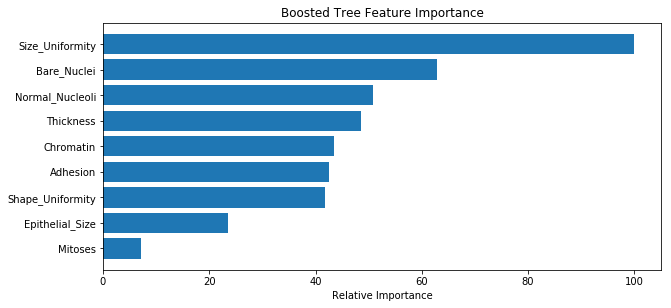

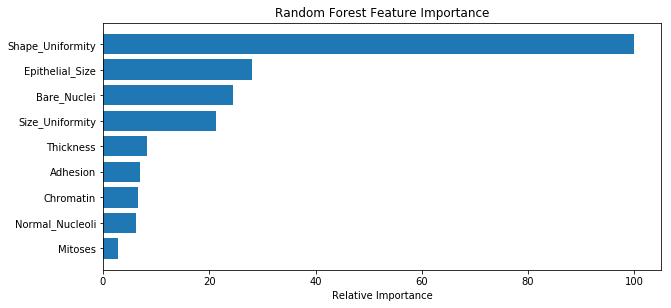

In [161]:
feature_importance_bt = bdt_dr.feature_importances_

# Make importances relative to max importance.
feature_importance_bt = 100.0 * (feature_importance_bt / feature_importance_bt.max())
sorted_idx_bt = np.argsort(feature_importance_bt)
pos_bt = np.arange(sorted_idx_bt.shape[0]) + .5
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 2)
plt.barh(pos_bt, feature_importance_bt[sorted_idx_bt], align='center')
plt.yticks(pos_bt, X_dr.columns[sorted_idx_bt])
plt.xlabel('Relative Importance')
plt.title('Boosted Tree Feature Importance')
plt.show()

feature_importance_rf = rfc_dr.feature_importances_

# Make importances relative to max importance.
feature_importance_rf = 100.0 * (feature_importance_rf / feature_importance_rf.max())
sorted_idx_rf = np.argsort(feature_importance_rf)
pos_rf = np.arange(sorted_idx_rf.shape[0]) + .5
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 2)
plt.barh(pos_rf, feature_importance_rf[sorted_idx_rf], align='center')
plt.yticks(pos_rf, X_dr.columns[sorted_idx_rf])
plt.xlabel('Relative Importance')
plt.title('Random Forest Feature Importance')
plt.show()

Both the Boosted and Random Forest model call __Shape_Uniformity__ the most important feature, the Random Forest calls it the most important by far. Additionally,  both models agree that __Mitosis__ is the least most important feature. After that, the feature importance of both stops perfectly lining up.

Both models call __Bare_Nulcei__ very important, another reason why the dropped column models performed so much worse. Addtionally, both models think that __Size Uniformity__ is a trait of middling importance.  

Aside from that, both model's feature importance vary wildly, partially due to just how much the Random Forest overvalues Shape_Uniformity, appearing as more than doubly important to the Random Forest, while the rankings remain relatively similar. Still, the biggest discrepancy is __Epithelial_Size__ and __Normal_Nuclei__, appearing to the Boosted Decision Tree as the second least important and second most important respectively, but appearing as just the oppsite, the second most important and second least important respectively to the Random Forest.

# Feature Importance Conclusion

Because of the varying nature of both model's feautre importance predictions, it is impossible for me to get a perfect idea of the feature importance. I know that the Shape Uniformity of the tumor is the most important by a lot, and that the amount of Mitosis going on in the tumor is the least important by a fair margin. After that, I know that how promenent the appearance of a Bare Nulcei is is also very important. From there, I know that the Epithelial Size of the tumor and how Normal the Nuclei appears also might have some importance. After that, I can say that the tumor Thickness, Adhension, and Cromatin levels are more important than its Mitotis, and probably less important than all other mentioned features.

http://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29